<a href="https://colab.research.google.com/github/aaaven/aiarts2020online/blob/master/week08_DeepDream/DeepDreaming_with_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDreaming with Layers


#### author info 

* by Aven Le ZHOU (https://www.aven.cc)
* artMahcines & NYU Shanghai
* aiarts, Fall 2020
* https://github.com/artmachines/aiarts2020online

#### credits

* Original code implementation from ___Alex Mordvintsev___ [colab link](https://colab.research.google.com/drive/1DWcrN9WXni58MbddvlShX0wF_oeo8W_0)
* adapted by Aven for aiarts 2020 course

#### orginal notes from ___Alex Mordvintsev___
This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

#### update functions by ___Aven Le ZHOU___
1. apply scale and deepdream recursively
2. save step by step frames, and convert the frames into videos
3. add parametric controls on the generative process such as choosing layers, zoom-in scales and video length

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/0-Colab-Assets/deepdream"
image_path = "/content/drive/My Drive/0-Colab-Assets/deepdream/eye.jpg".format(file_path)
image_contents = open(image_path).read()

Mounted at /content/drive


### 1) Set up

In [ ]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
# !wget -nc https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg


from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
# import tensorflow as tf
import tensorflow
import tensorflow.compat.v1 as tf

from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

img0 = sess.run(tf.image.decode_image(image_contents))

# showarray(img0)

# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

--2020-11-17 03:17:06--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 64.233.166.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  20.0MB/s    in 2.4s    

2020-11-17 03:17:10 (20.0 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 


W1117 03:17:13.942310 140468223805312 deprecation.py:323] From <ipython-input-2-0cafd71b41a7>:20: __init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


### 2) Let's deep dream ! -- Customize your own neural style

You can adjust the sliders to change the strength of the deep dream, and how many scales it is applied over.

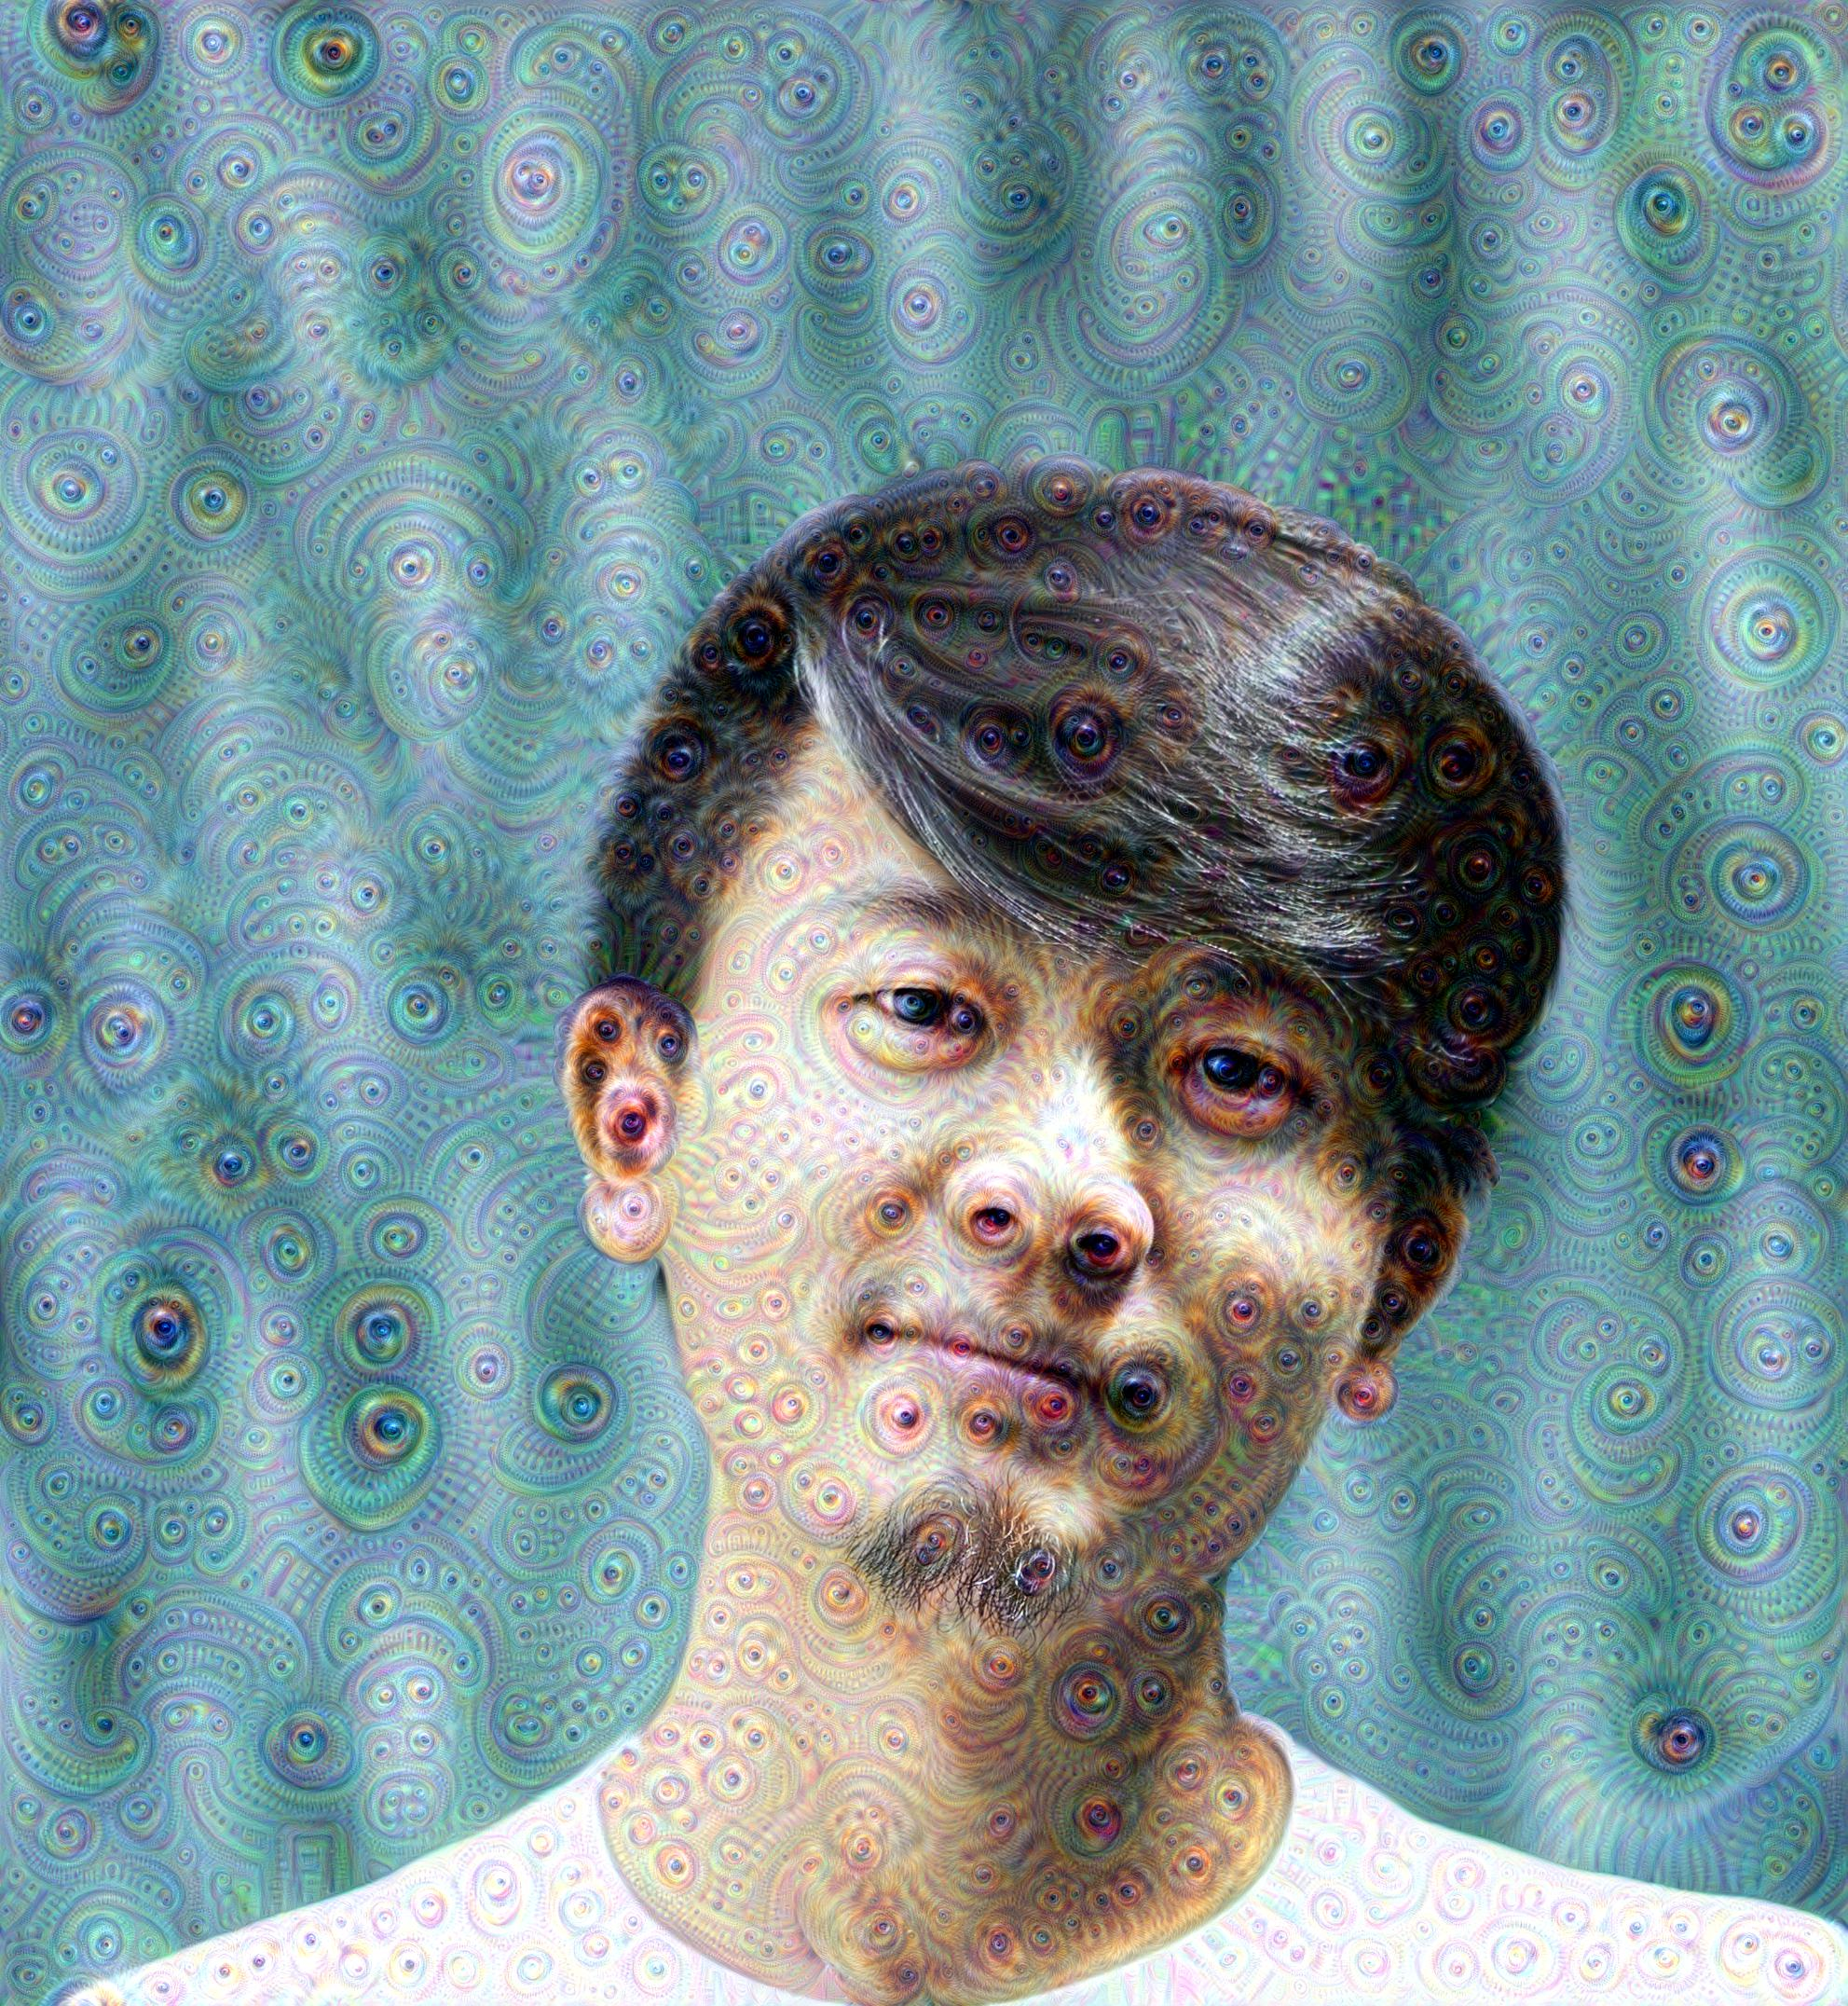

In [ ]:
octave_n = 5 #@param {type:"slider", max: 10}
octave_scale =  1.8#@param {type:"number"}
iter_n = 14 #@param {type:"slider", max: 50}
strength = 174 #@param {type:"slider", max: 1000}
layer = "mixed4a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img0)


### 3) Zoom in and DeepDream iteratively

Loop/Zoom + deepdream!

In [ ]:
dreaming_steps = 12 #@param {type:"slider", max: 512}
zooming_steps = 12 #@param {type:"slider", max: 512}
zoom_factor = 1.4 #@param {type:"number"}

frame = img0
img_y, img_x, _ = img0.shape

clear_output()

# prep video
import cv2
video_name = "{}/deepdream-inclass.mov".format(file_path)
height, width, _ = final.shape
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('M','J','P','G'), fps=24, frameSize=(width,height))

frame_num = dreaming_steps + zooming_steps
for i in range(frame_num):
  frame = render_deepdream(tf.square(T(layer)), frame, False)
  # clear_output()
  # showarray(frame)
  print("{} out of {} frames done".format(i,frame_num))
  
  # write frames
  a = np.uint8(np.clip(frame, 0, 255))
  b = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)
  video.write(b)

  # update the size / zoom in
  if(i > dreaming_steps - 1):
    newsize = np.int32(np.float32(frame.shape[:2])*zoom_factor)
    frame = resize(frame, newsize)
    frame = frame[(newsize[0]-img_y)//2:(newsize[0]-img_y)//2+img_y,
                  (newsize[1]-img_x)//2:(newsize[1]-img_x)//2+img_x,:]
    a = np.uint8(np.clip(frame, 0, 255))
    b = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    # write the last frame, to continue the video
    if(i >= frame_num - 1):
      pick_up = '{}/pick_up.png'.format(file_path)
      cv2.imwrite(pick_up,b)

    video.write(b)
    


cv2.destroyAllWindows()
video.release()

print("{} is ready".format(video_name))  

0 out of 24 frames done
1 out of 24 frames done
2 out of 24 frames done
3 out of 24 frames done
4 out of 24 frames done
5 out of 24 frames done
6 out of 24 frames done
7 out of 24 frames done
8 out of 24 frames done
9 out of 24 frames done
10 out of 24 frames done
11 out of 24 frames done
12 out of 24 frames done
13 out of 24 frames done
14 out of 24 frames done
15 out of 24 frames done
16 out of 24 frames done
17 out of 24 frames done
18 out of 24 frames done
19 out of 24 frames done
20 out of 24 frames done
21 out of 24 frames done
22 out of 24 frames done
23 out of 24 frames done
/content/drive/My Drive/0-Colab-Assets/deepdream/deepdream-inclass.mov is ready


### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe